# Import Libraries & Packages

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns

In [2]:
import sys
sys.path.append('../lending_club')
import config

# Import Approved Loan Data

In [4]:
approved = pd.read_pickle('../data/approved.pickle')

In [ ]:
from model_prep import divide_by_term

three_year = divide_by_term(approved, 36)
five_year = divide_by_term(approved, 60)
approved = pd.concat([three_year,five_year],axis=0)

#### What are the interest rates for each loan grade?

[Text(0, 0.5, 'Sub Grade'),
 Text(0.5, 0, 'Interest Rate'),
 Text(0.5, 1.0, 'Interest Rate by Sub Grade')]

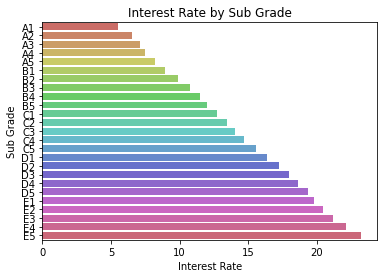

In [18]:
byGrade = approved.groupby(['sub_grade'])[['int_rate']].mean().reset_index()

fig = sns.barplot(
    data = byGrade,
    y = 'sub_grade', x = 'int_rate', palette = 'hls')

fig.set(title = 'Interest Rate by Sub Grade', ylabel = 'Sub Grade', xlabel = 'Interest Rate')

#### Which states are the most common?

In [5]:
approved['addr_state'].value_counts().head(5)

CA    190540
TX    106795
NY    106201
FL     92665
IL     50209
Name: addr_state, dtype: int64

In [18]:
pop = pd.read_csv('../data/population.csv', skiprows = 3)
pop = pop.iloc[5:56]
pop.rename(columns = {'Unnamed: 0': 'State'}, inplace = True)
pop.drop(['Census', 'Estimates Base', '2016', '2017', '2018', '2019'], axis = 1, inplace = True)

In [19]:
pop['State'] = pop['State'].str.replace('.','')

<ipython-input-19-445b849bc40a>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  pop['State'] = pop['State'].str.replace('.','')


In [20]:
# Dropped District of Columbia
pop.drop(index = 13, inplace = True)

In [21]:
for column in ['2010', '2011', '2012', '2013', '2014', '2015']:
    pop[column] = pop[column].str.replace(',','').astype(int)

In [22]:
State = {
'Alabama': 'AL',
'Alaska': 'AK',
'Arizona': 'AZ',
'Arkansas': 'AR',
'California': 'CA',
'Colorado': 'CO',
'Connecticut': 'CT',
'Delaware': 'DE',
'Florida': 'FL',
'Georgia': 'GA',
'Hawaii': 'HI',
'Idaho': 'ID',
'Illinois': 'IL',
'Indiana': 'IN',
'Iowa': 'IA',
'Kansas': 'KS',
'Kentucky': 'KY',
'Louisiana': 'LA',
'Maine': 'ME',
'Maryland': 'MD',
'Massachusetts': 'MA',
'Michigan': 'MI',
'Minnesota': 'MN',
'Mississippi': 'MS',
'Missouri': 'MO',
'Montana': 'MT',
'Nebraska': 'NB',
'Nevada': 'NV',
'New Hampshire': 'NH',
'New Jersey': 'NJ',
'New Mexico': 'NM',
'New York': 'NY',
'North Carolina': 'NC',
'North Dakota': 'ND',
'Ohio': 'OH',
'Oklahoma': 'OK',
'Oregon': 'OR',
'Pennsylvania': 'PA',
'Rhode Island': 'RI',
'South Carolina': 'SC',
'South Dakota': 'SD',
'Tennessee': 'TN',
'Texas': 'TX',
'Utah': 'UT',
'Vermont': 'VT',
'Virginia': 'VA',
'Washington': 'WA',
'West Virginia': 'WV',
'Wisconsin': 'WI',
'Wyoming': 'WY'
}

In [23]:
pop['State Abbr'] = pop['State'].replace(State)

In [24]:
pop['Avg Population'] = (pop['2010'] + pop['2011'] + pop['2012'] + pop['2013'] + pop['2014'] + pop['2015']) / 6
pop['Avg Population'] = pop['Avg Population'].astype(int)

In [26]:
pop = pop.iloc[:,7:]

In [27]:
pop

,State Abbr,Avg Population
5,AL,4820720
6,AK,729555
7,AZ,6604607
8,AR,2953272
9,CA,38113745
10,CO,5238477
11,CT,3589738
12,DE,919911
14,FL,19466195
15,GA,9938991


In [28]:
pop = pop.merge(pd.DataFrame(approved['addr_state'].value_counts().reset_index()).rename(columns = {'index': 'State Abbr'}))

In [29]:
pop['Loans per Capita'] = pop['addr_state'] / pop['Avg Population']

In [30]:
pop['Loans per Capita'] = round(pop['Loans per Capita'], 5) * 10000

In [31]:
byCapita = pop.sort_values(by = 'Loans per Capita', ascending = False).head(10)

[Text(0, 0.5, 'Loans per 10,000 residents'),
 Text(0.5, 0, 'State'),
 Text(0.5, 1.0, 'Top 10 States')]

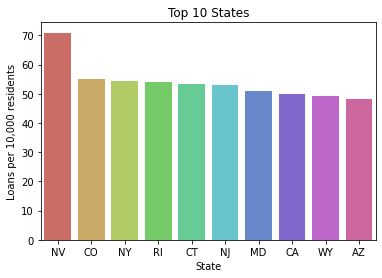

In [32]:
fig = sns.barplot(
    data = byCapita,
    y = 'Loans per Capita', x = 'State Abbr', palette = 'hls')

fig.set(title = 'Top 10 States', ylabel = 'Loans per 10,000 residents', xlabel = 'State')

### Most Frequent Zip Codes

In [33]:
approved['zip_code'].value_counts().head(10)

945xx    14555
750xx    14029
112xx    13339
606xx    12090
300xx    11699
331xx    10968
070xx    10424
891xx    10294
100xx    10273
900xx    10267
Name: zip_code, dtype: int64

- 945: Oakland, CA - Vicinity
- 750: Dallas, TX - North
- 112: Brooklyn, NY
- 606: Chicago, IL - Main1
- 300: Atlanta, GA - East
- 331: Miami, FL - Main1
- 070: Newark, NJ - Vicinity
- 891: Las Vegas, NV - Main
- 100: New York, NY - Main
- 900: Los Angeles, CA - Main

#### What loan durations are most common?

In [34]:
byDuration = pd.DataFrame(approved['term'].value_counts()).reset_index()
byDuration.rename(columns = {'index': 'term', 'term': 'count'}, inplace = True)

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Loan Duration (in months)'),
 Text(0.5, 1.0, 'Loan Durations')]

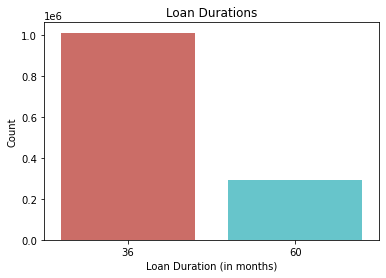

In [35]:
fig = sns.barplot(y = 'count', x = 'term', data = byDuration, palette = 'hls')

fig.set(title = 'Loan Durations', ylabel = 'Count', xlabel = 'Loan Duration (in months)')

#### What are the most common loan purposes?

In [40]:
byPurpose = pd.DataFrame(approved['purpose'].value_counts()).reset_index()
byPurpose.rename(columns = {'index': 'purpose', 'purpose': 'count'}, inplace = True)
byPurpose = byPurpose.sort_values('count', ascending = False)

[Text(0, 0.5, 'Loan Purpose'), Text(0.5, 1.0, 'Frequency of Loan Purposes')]

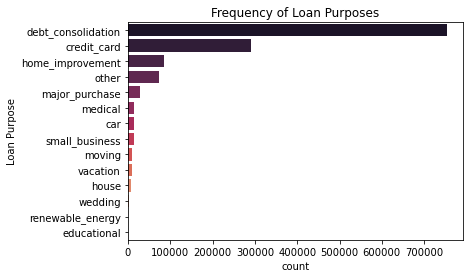

In [42]:
fig = sns.barplot(y = 'purpose', x = 'count', data = byPurpose, palette = 'rocket')

fig.set(title = 'Frequency of Loan Purposes', ylabel = 'Loan Purpose')

In [94]:
g = approved[approved['annual_inc'] < 150000]

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

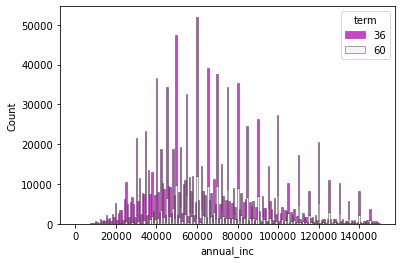

In [95]:
sns.histplot(
    data = g,
    x="annual_inc", hue="term",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5
).xlim(0,150000)

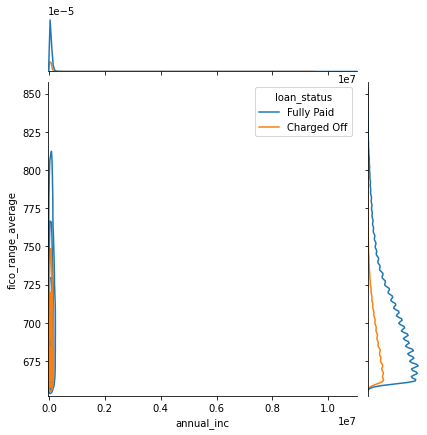

In [93]:
sns.jointplot(data=approved, x="annual_inc", y="fico_range_average", hue="loan_status", kind="kde")

In [64]:
approved.columns

Index(['addr_state', 'annual_inc', 'application_type', 'disbursement_method',
       'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high',
       'fico_range_low', 'grade', 'home_ownership', 'initial_list_status',
       'installment', 'int_rate', 'issue_d', 'loan_amnt', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'sub_grade', 'term',
       'verification_status', 'zip_code', 'loan_status', 'fico_range_average'],
      dtype='object')

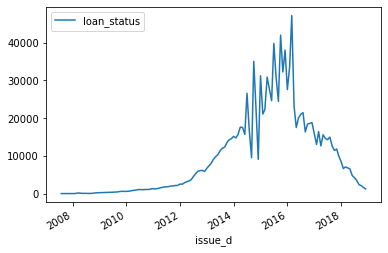

In [45]:
approved[['issue_d', 'loan_status']].groupby(['issue_d']).count().plot()